## General network properties: Articulation points and bridges

In [43]:

import pandas as pd
import seaborn as sns
import networkx as nx
import dataframe_image as dfi
import decimal
from statistics import mean

import config
from config import INTERACTOMES_PATH, DATA_REACTOME_PATH, PATHWAY_GRAPHS_PATH, genes, proteoforms
from lib.networks import get_interactomes, get_multiindex, get_combinations, create_pathway_interaction_network, get_combinations_with_pathways

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

config.set_root_wd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Initial working directory: C:\git\ProteoformNetworks\src\Python
New working directory: C:\git\ProteoformNetworks


## For each interactome

In [44]:
index = get_multiindex()
interactomes_no_sm, interactomes_with_sm, interactomes_with_unique_sm = get_interactomes(DATA_REACTOME_PATH,
                                                                                         INTERACTOMES_PATH)
interactomes = [interactomes_no_sm[genes], interactomes_no_sm[proteoforms], interactomes_with_sm[genes],
                interactomes_with_sm[proteoforms], interactomes_with_unique_sm[genes],
                interactomes_with_unique_sm[proteoforms]]

Reading participants of all reactions for level genes...
Reading participants of all reactions for level proteins...
Reading participants of all reactions for level proteoforms...
Reading participants of all reactions for level sm...
Reading components of all complexes for level genes...
Reading components of all complexes for level proteins...
Reading components of all complexes for level proteoforms...
Reading components of all complexes for level sm...
Reading interaction network for  at genes level, method no_sm...
Reading interaction network for  at proteins level, method no_sm...
Reading interaction network for  at proteoforms level, method no_sm...
Reading interaction network for  at genes level, method with_sm...
Reading interaction network for  at proteins level, method with_sm...
Reading interaction network for  at proteoforms level, method with_sm...
Reading interaction network for  at genes level, method with_unique_sm...
Reading interaction network for  at proteins level, 

## Create table by interactomes


In [45]:
cols_art_points = ["Art. Points", "% Art. Points", "AE", "% AE", "SM", "% SM", ]
cols_bridges = ["Bridges", "% Bridges", "% Bridges out of AE", "% Bridges out of SM"]
columns = [
    *cols_art_points, *cols_bridges
]


def get_percentage_links_that_are_bridges(g, nodes):
    percentage_bridges_from_node = []
    for node in nodes:
        if len(g.edges(node)) > 0:
            num_bridges = sum(g.edges[e]['Bridge'] for e in g.edges(node))
            percentage_bridges_from_node.append(num_bridges / len(g.edges(node)))
        else:
            percentage_bridges_from_node.append(0)
    return round(mean(percentage_bridges_from_node) * 100, 2)


def get_tuples(i):
    percentage_art_points = round(i.graph['Articulation Points'] / i.number_of_nodes() * 100, 2)
    num_acc_ent_art_points = sum(
        i.nodes[n]["Articulation Point"] and not i.nodes[n]['type'].startswith("S") for n in i.nodes)
    percentage_acc_ent_art_points = round(num_acc_ent_art_points / i.number_of_nodes() * 100, 2)
    num_sm_art_points = sum(i.nodes[n]["Articulation Point"] and i.nodes[n]['type'].startswith("S") for n in i.nodes)
    percentage_sm_art_points = 0
    if i.graph['num_small_molecules'] > 0:
        percentage_sm_art_points = round(num_sm_art_points / i.number_of_nodes() * 100, 2)
    assert i.graph['Articulation Points'] == num_acc_ent_art_points + num_sm_art_points

    percentage_bridges = round(decimal.Decimal(i.graph["Bridges"]) / i.number_of_edges() * 100, 2)
    acc_ents = list(i.nodes)
    percentage_from_sms = 0
    if i.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in i.nodes if not i.nodes[n]['type'].startswith("S")]
        sms = [n for n in i.nodes if i.nodes[n]['type'].startswith("S")]
        percentage_from_sms = get_percentage_links_that_are_bridges(i, sms)
    percentage_from_acc_ents = get_percentage_links_that_are_bridges(i, acc_ents)

    return (
        i.graph['Articulation Points'],
        percentage_art_points,
        num_acc_ent_art_points,
        percentage_acc_ent_art_points,
        num_sm_art_points,
        percentage_sm_art_points,
        i.graph["Bridges"],
        percentage_bridges,
        percentage_from_acc_ents,
        percentage_from_sms
    )


df_br_ap = pd.DataFrame([get_tuples(interactome) for interactome in interactomes],
                        columns=columns,
                        index=index)
dfi.export(df_br_ap[cols_art_points], 'figures/table_interactomes_art_points.png')
df_br_ap[cols_art_points]

Art. Points  % Art. Points    AE  % AE  \
Small Molecules          Entity Level                                           
Not Included             genes                 267           2.43   267  2.43   
                         proteoforms           351           2.46   351  2.46   
Included                 genes                 244           1.87   143  1.10   
                         proteoforms           254           1.56   151  0.93   
Reaction-Unique Included genes                2012           4.96  1600  3.94   
                         proteoforms          2050           4.68  1638  3.74   

                                        SM  % SM  
Small Molecules          Entity Level             
Not Included             genes           0  0.00  
                         proteoforms     0  0.00  
Included                 genes         101  0.77  
                         proteoforms   103  0.63  
Reaction-Unique Included genes         412  1.02  
                         proteoforms   412  0.94

In [46]:
dfi.export(df_br_ap[cols_bridges], 'figures/table_interactomes_bridges.png')
df_br_ap[cols_bridges]

Bridges % Bridges  % Bridges out of AE  \
Small Molecules          Entity Level                                           
Not Included             genes             511      0.14                 5.41   
                         proteoforms       582      0.10                 4.81   
Included                 genes             523      0.12                 4.49   
                         proteoforms       527      0.08                 3.52   
Reaction-Unique Included genes            3444      0.43                 5.87   
                         proteoforms      3356      0.32                 4.63   

                                       % Bridges out of SM  
Small Molecules          Entity Level                       
Not Included             genes                        0.00  
                         proteoforms                  0.00  
Included                 genes                        3.53  
                         proteoforms                  3.55  
Reaction-Unique Included genes                       11.07  
                         proteoforms                 10.79

In [47]:
data = {
    "Bottleneck": ["Articulation Points"] * 6,
    "Percentage": df_br_ap["% Art. Points"]
}
df_art_points = pd.DataFrame(data)
df_art_points.reset_index(inplace=True)

data = {
    "Bottleneck": ["Bridges"] * 6,
    "Percentage": df_br_ap["% Bridges"]
}
df_bridges = pd.DataFrame(data)
df_bridges.reset_index(inplace=True)

data_br_ap = pd.concat([df_art_points, df_bridges])
data_br_ap

,Small Molecules,Entity Level,Bottleneck,Percentage
0,Not Included,genes,Articulation Points,2.43
1,Not Included,proteoforms,Articulation Points,2.46
2,Included,genes,Articulation Points,1.87
3,Included,proteoforms,Articulation Points,1.56
4,Reaction-Unique Included,genes,Articulation Points,4.96
5,Reaction-Unique Included,proteoforms,Articulation Points,4.68
0,Not Included,genes,Bridges,0.14
1,Not Included,proteoforms,Bridges,0.10
2,Included,genes,Bridges,0.12
3,Included,proteoforms,Bridges,0.08


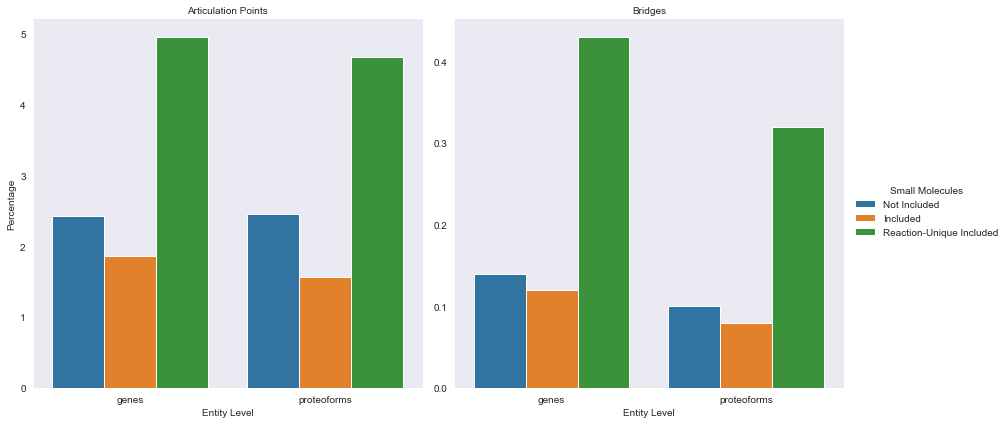

In [48]:
sns.set_style("dark")
f = sns.catplot(x="Entity Level",
                y="Percentage",
                hue="Small Molecules",
                col="Bottleneck",
                data=data_br_ap,
                kind="bar",
                height=6, aspect=1, sharey=False)
f.set_titles("{col_name}")

## For each pathway

In [49]:
proteoforms_no_annotations = [node for node in interactomes_no_sm['proteoforms'].nodes if not any((c in {':', '-'}) for c in str(node))]
proteoforms_with_annotations = [node for node in interactomes_no_sm['proteoforms'].nodes if any((c in {':', '-'}) for c in str(node))]

pathways_map = nx.get_node_attributes(interactomes_no_sm[proteoforms], "pathways")
selected_pathways = set()

for proteoform in proteoforms_with_annotations:
    for pathway in pathways_map[proteoform]:
        selected_pathways.add(pathway)
print(f"There are {len(selected_pathways)} pathways with proteoforms with annotations.")
df_selected_pathways = pd.DataFrame(selected_pathways, columns=["Pathway"])
df_selected_pathways.sort_values(by=["Pathway"], inplace=True)
df_selected_pathways

There are 1119 pathways with proteoforms with annotations.


,Pathway
1103,R-HSA-1059683
502,R-HSA-109704
653,R-HSA-110056
1070,R-HSA-110312
577,R-HSA-110314
...,...
304,R-HSA-977347
445,R-HSA-977606
187,R-HSA-982772
404,R-HSA-983231


In [50]:
def get_tuples(combination):
    g = create_pathway_interaction_network(
        method=combination[0], level=combination[1], pathway=combination[2], out_path=PATHWAY_GRAPHS_PATH
    )

    percentage_art_points = round(g.graph['Articulation Points'] / g.number_of_nodes() * 100, 2)
    num_acc_ent_art_points = sum(g.nodes[n]["Articulation Point"] and not g.nodes[n]['type'].startswith("S") for n in g.nodes)
    percentage_acc_ent_art_points = round(num_acc_ent_art_points / g.number_of_nodes() * 100, 2)
    num_sm_art_points = sum(g.nodes[n]["Articulation Point"] and g.nodes[n]['type'].startswith("S") for n in g.nodes)
    percentage_sm_art_points = 0
    if g.graph['num_small_molecules'] > 0:
        percentage_sm_art_points = round(num_sm_art_points / g.number_of_nodes() * 100, 2)
    assert g.graph['Articulation Points'] == num_acc_ent_art_points + num_sm_art_points

    percentage_bridges = 0
    if g.number_of_edges() > 0:
        percentage_bridges = round(decimal.Decimal(g.graph["Bridges"]) / g.number_of_edges(), 2)
    acc_ents = list(g.nodes)
    percentage_from_sms = 0
    if g.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in g.nodes if not g.nodes[n]['type'].startswith("Simple")]
        sms = [n for n in g.nodes if g.nodes[n]['type'].startswith("Simple")]
        percentage_from_sms = get_percentage_links_that_are_bridges(g, sms)
    percentage_from_acc_ents = get_percentage_links_that_are_bridges(g, acc_ents)

    return (
        combination[0], combination[1], combination[2],
        g.graph['Articulation Points'], percentage_art_points, num_acc_ent_art_points, percentage_acc_ent_art_points, num_sm_art_points, percentage_sm_art_points,
        g.graph["Bridges"], percentage_bridges, percentage_from_acc_ents, percentage_from_sms
    )
columns = [ "Small Molecules", "Entity Level", "Pathway", *cols_art_points, *cols_bridges]
df_br_ap_pathways = pd.DataFrame([get_tuples(combination) for combination in get_combinations_with_pathways(df_selected_pathways["Pathway"])], columns=columns)
df_br_ap_pathways

,Small Molecules,Entity Level,Pathway,Art. Points,% Art. Points,AE,% AE,SM,% SM,Bridges,% Bridges,% Bridges out of AE,% Bridges out of SM
0,no_sm,genes,R-HSA-1059683,0,0.00,0,0.00,0,0.00,0,0.00,0.00,0.00
1,no_sm,genes,R-HSA-109704,0,0.00,0,0.00,0,0.00,0,0.00,0.00,0.00
2,no_sm,genes,R-HSA-110056,1,10.00,1,10.00,0,0.00,1,0.03,11.11,0.00
3,no_sm,genes,R-HSA-110312,0,0.00,0,0.00,0,0.00,0,0.00,0.00,0.00
4,no_sm,genes,R-HSA-110314,0,0.00,0,0.00,0,0.00,0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6709,with_unique_sm,proteoforms,R-HSA-977347,4,10.26,2,5.13,2,5.13,10,0.20,60.85,20.00
6710,with_unique_sm,proteoforms,R-HSA-977606,3,2.00,3,2.00,0,0.00,5,0.00,3.04,10.00
6711,with_unique_sm,proteoforms,R-HSA-982772,1,1.85,1,1.85,0,0.00,1,0.00,2.96,0.00
6712,with_unique_sm,proteoforms,R-HSA-983231,4,2.35,4,2.35,0,0.00,2,0.00,1.60,4.17


In [51]:
df_br_ap_pathways.dtypes

Small Molecules         object
Entity Level            object
Pathway                 object
Art. Points              int64
% Art. Points          float64
AE                       int64
% AE                   float64
SM                       int64
% SM                   float64
Bridges                  int64
% Bridges               object
% Bridges out of AE    float64
% Bridges out of SM    float64
dtype: object

In [52]:
df_pathways_grouped = df_br_ap_pathways.groupby(['Small Molecules', 'Entity Level']).agg(
    {
        "Art. Points": ['mean'],
        "% Art. Points": ['mean'],
        "AE": ['mean'],
        "% AE": ['mean'],
        "SM": ['mean'],
        "% SM": ['mean'],
        "Bridges": ['mean'],
        "% Bridges": ['mean'],
        "% Bridges out of AE": ['mean'],
        "% Bridges out of SM": ['mean']
    })
df_pathways_grouped.columns = [ *cols_art_points, *cols_bridges]
df_pathways_grouped = df_pathways_grouped.set_index(get_multiindex())
df_pathways_grouped

Art. Points  % Art. Points   AE  % AE  \
Small Molecules          Entity Level                                          
Not Included             genes                0.74           3.03 0.74  3.03   
                         proteoforms          1.02           3.92 1.02  3.92   
Included                 genes                0.86           2.86 0.58  2.05   
                         proteoforms          0.91           2.65 0.62  1.88   
Reaction-Unique Included genes                1.67           3.68 1.45  3.31   
                         proteoforms          1.71           3.42 1.49  3.06   

                                        SM  % SM  Bridges  % Bridges  \
Small Molecules          Entity Level                                  
Not Included             genes        0.00  0.00     2.03       0.10   
                         proteoforms  0.00  0.00     2.28       0.10   
Included                 genes        0.28  0.80     1.43       0.04   
                         proteoforms  0.29  0.78     1.42       0.03   
Reaction-Unique Included genes        0.23  0.37     3.17       0.05   
                         proteoforms  0.23  0.36     3.08       0.04   

                                       % Bridges out of AE  \
Small Molecules          Entity Level                        
Not Included             genes                       10.94   
                         proteoforms                 11.14   
Included                 genes                        6.66   
                         proteoforms                  5.43   
Reaction-Unique Included genes                        7.72   
                         proteoforms                  6.37   

                                       % Bridges out of SM  
Small Molecules          Entity Level                       
Not Included             genes                        0.00  
                         proteoforms                  0.00  
Included                 genes                        2.74  
                         proteoforms                  2.38  
Reaction-Unique Included genes                        7.45  
                         proteoforms                  6.91

In [53]:
dfi.export(df_pathways_grouped[cols_art_points], 'figures/table_pathways_art_points.png')
df_pathways_grouped[cols_art_points]

Art. Points  % Art. Points   AE  % AE  \
Small Molecules          Entity Level                                          
Not Included             genes                0.74           3.03 0.74  3.03   
                         proteoforms          1.02           3.92 1.02  3.92   
Included                 genes                0.86           2.86 0.58  2.05   
                         proteoforms          0.91           2.65 0.62  1.88   
Reaction-Unique Included genes                1.67           3.68 1.45  3.31   
                         proteoforms          1.71           3.42 1.49  3.06   

                                        SM  % SM  
Small Molecules          Entity Level             
Not Included             genes        0.00  0.00  
                         proteoforms  0.00  0.00  
Included                 genes        0.28  0.80  
                         proteoforms  0.29  0.78  
Reaction-Unique Included genes        0.23  0.37  
                         proteoforms  0.23  0.36

In [54]:
dfi.export(df_pathways_grouped[cols_bridges], 'figures/table_pathways_bridges.png')
df_pathways_grouped[cols_bridges]

Bridges  % Bridges  \
Small Molecules          Entity Level                       
Not Included             genes            2.03       0.10   
                         proteoforms      2.28       0.10   
Included                 genes            1.43       0.04   
                         proteoforms      1.42       0.03   
Reaction-Unique Included genes            3.17       0.05   
                         proteoforms      3.08       0.04   

                                       % Bridges out of AE  \
Small Molecules          Entity Level                        
Not Included             genes                       10.94   
                         proteoforms                 11.14   
Included                 genes                        6.66   
                         proteoforms                  5.43   
Reaction-Unique Included genes                        7.72   
                         proteoforms                  6.37   

                                       % Bridges out of SM  
Small Molecules          Entity Level                       
Not Included             genes                        0.00  
                         proteoforms                  0.00  
Included                 genes                        2.74  
                         proteoforms                  2.38  
Reaction-Unique Included genes                        7.45  
                         proteoforms                  6.91

ValueError: Could not interpret input 'Percentage of articulation point nodes'

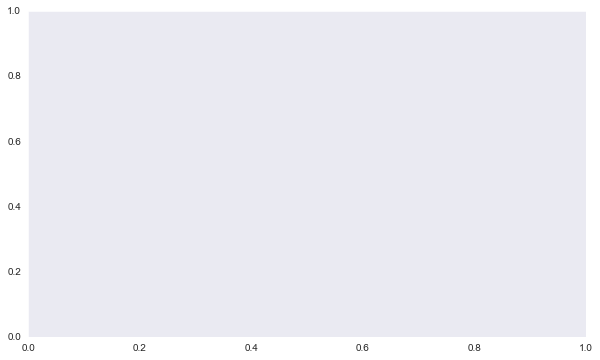

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
f = sns.violinplot(x="Small Molecules", y="Percentage of articulation point nodes", hue="Entity Level",
                   data=df_br_ap_pathways, palette=config.COLORS_BORDER)
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$")) # Convert ticks to powers of 10
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("Percentage of articulation point nodes in Pathways")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
df_br_ap_pathways["Percentage of bridge links"] = df_br_ap_pathways["Percentage of bridge links"].astype('float64')
f2 = sns.violinplot(x="Small Molecules", y="Percentage of bridge links", hue="Entity Level",
                    data=df_br_ap_pathways, palette=config.COLORS_BORDER)
f2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f2.set_title("Percentage of bridge links in Pathways")

In [ ]:
data = {
    "Bottleneck": ["Articulation Points"] * len(df_br_ap_pathways),
    "Small Molecules": df_br_ap_pathways["Small Molecules"],
    "Entity Level": df_br_ap_pathways["Entity Level"],
    "Pathway": df_br_ap_pathways["Pathway"],
    "Percentage": df_br_ap_pathways["Percentage of articulation point nodes"]
}
df_art_points = pd.DataFrame(data)
df_art_points

In [ ]:
data = {
    "Bottleneck": ["Bridges"] * len(df_br_ap_pathways),
    "Small Molecules": df_br_ap_pathways["Small Molecules"],
    "Entity Level": df_br_ap_pathways["Entity Level"],
    "Pathway": df_br_ap_pathways["Pathway"],
    "Percentage": df_br_ap_pathways["Percentage of bridge links"]
}
df_bridges = pd.DataFrame(data)
df_bridges

In [ ]:
data_br_ap = pd.concat([df_art_points, df_bridges])
data_br_ap

In [ ]:
sns.set_style("dark")
f = sns.catplot(x="Entity Level",
                y="Percentage",
                hue="Small Molecules",
                col="Bottleneck",
                data=data_br_ap,
                kind="violin",
                height=6, aspect=1, sharey=False)
f.set_titles("{col_name}")